In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

In [5]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [6]:
max_words = 2000
max_len = 40
num_classes = 1

In [7]:
epochs = 20
batch_size = 512
print_batch_n = 100

In [12]:
df_train = pd.read_csv("leto_train.csv")
df_val = pd.read_csv("leto_test.csv")

In [13]:
df_train.head(10)

,Rating,Content,Class
0,4,Пока ещё не во всем разобралась,1
1,1,"Пыталась скачать,качает и сбрасывает",0
2,4,"Удобно,быстро",1
3,2,"Все нравится, не работает оплата по штих коду....",0
4,1,После ввода пароля вылетает,0
5,5,"Отличное приложение, спасибо Вам.",1
6,5,Отлично!,1
7,5,Мне нравится,1
8,5,Отлично,1
9,5,Все ок,1


In [14]:
df_train.shape

(16660, 3)

In [15]:
sw = set(get_stop_words("russian"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [19]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() \
           if word not in sw]
    return " ".join(txt)

df_train['Content'] = df_train['Content'].apply(preprocess_text)
df_val['Content'] = df_val['Content'].apply(preprocess_text)

In [20]:
train_corpus = " ".join(df_train["Content"])
train_corpus = train_corpus.lower()

In [21]:
nltk.download("punkt")
tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Николай\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [23]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [27]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'удобный',
 'работать',
 'отлично',
 'отличный',
 'хороший',
 'обновление',
 'телефон',
 'супер']

In [28]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [29]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [30]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in\
                      df_train["Content"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in\
                    df_val["Content"]], dtype=np.int32)

In [31]:
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 225,
       779])

In [32]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128,
                 out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)       
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [33]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [34]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

train_dataset = DataWrapper(x_train, df_train['Class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['Class'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409


In [35]:
for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Train epoch 1/20
Step 0: loss=0.6481788754463196
Train epoch 2/20
Step 0: loss=0.2317860722541809
Train epoch 3/20
Step 0: loss=0.19361138343811035
Train epoch 4/20
Step 0: loss=0.1068677008152008
Train epoch 5/20
Step 0: loss=0.06346812099218369
Train epoch 6/20
Step 0: loss=0.06304210424423218
Train epoch 7/20
Step 0: loss=0.06094134598970413
Train epoch 8/20
Step 0: loss=0.03951101005077362
Train epoch 9/20
Step 0: loss=0.03925658017396927
Train epoch 10/20
Step 0: loss=0.0284358449280262
Train epoch 11/20
Step 0: loss=0.027567831799387932
Train epoch 12/20
Step 0: loss=0.027563542127609253
Train epoch 13/20
Step 0: loss=0.06399193406105042
Train epoch 14/20
Step 0: loss=0.03845905885100365
Train epoch 15/20
Step 0: loss=0.04359423741698265
Train epoch 16/20
Step 0: loss=0.02816244214773178
Train epoch 17/20
Step 0: loss=0.053176432847976685
Train epoch 18/20
Step 0: loss=0.0522603765130043
Train epoch 19/20
Step 0: loss=0.039996929466724396
Train epoch 20/20
Step 0: loss=0.01629076

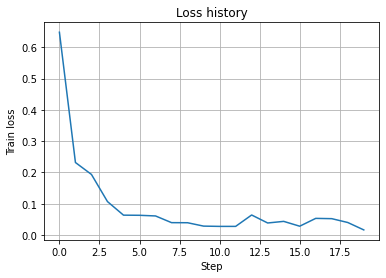

In [36]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history)